# Build HDF5 Container Input for GCN from Methylation Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font', family='Times New Roman')
import seaborn, h5py
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Load Sample Methylation Matrix

In [2]:
meth_all_samples = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_sample_matrix_450_1000bpprom.tsv',
                               sep='\t')
meth_all_samples.head()

,Symbol,TCGA-AB-2995-03A-01D-0741-05|laml|mean_beta_value_promoter,TCGA-AB-2995-03A-01D-0741-05|laml|support_promoter,TCGA-AB-2995-03A-01D-0741-05|laml|mean_beta_value_gene,TCGA-AB-2995-03A-01D-0741-05|laml|support_gene,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|support_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_gene,TCGA-2E-A9G8-01A-11D-A409-05|ucec|support_gene,TCGA-AB-2967-03A-01D-0742-05|laml|mean_beta_value_promoter,...,TCGA-A6-5656-01B-02D-A27A-05|coad|mean_beta_value_gene,TCGA-A6-5656-01B-02D-A27A-05|coad|support_gene,TCGA-AF-A56K-01A-32D-A39G-05|read|mean_beta_value_promoter,TCGA-AF-A56K-01A-32D-A39G-05|read|support_promoter,TCGA-AF-A56K-01A-32D-A39G-05|read|mean_beta_value_gene,TCGA-AF-A56K-01A-32D-A39G-05|read|support_gene,TCGA-A6-6652-01A-11D-1772-05|coad|mean_beta_value_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|support_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|mean_beta_value_gene,TCGA-A6-6652-01A-11D-1772-05|coad|support_gene
0,NOC2L,0.532382,14.0,0.611618,137.0,0.335770,14.0,0.527036,137.0,0.537173,...,0.665979,137.0,0.395022,14.0,0.608445,137.0,0.402937,14.0,0.674268,137.0
1,KLHL17,0.385336,9.0,0.757341,53.0,0.253512,9.0,0.661084,53.0,0.286157,...,0.723631,53.0,0.307415,9.0,0.700557,53.0,0.320929,9.0,0.703918,53.0
2,HES4,0.612174,13.0,0.164699,5.0,0.560581,13.0,0.122429,5.0,0.647446,...,0.218370,5.0,0.590674,13.0,0.155521,5.0,0.667483,13.0,0.206909,5.0
3,ISG15,0.412785,14.0,0.586096,246.0,0.354375,14.0,0.421966,246.0,0.411279,...,0.590399,246.0,0.339227,14.0,0.525120,246.0,0.367379,14.0,0.578820,245.0
4,AGRN,0.586864,21.0,0.651901,507.0,0.440767,21.0,0.490208,507.0,0.613114,...,0.671246,507.0,0.523439,21.0,0.600631,507.0,0.520950,20.0,0.652329,506.0


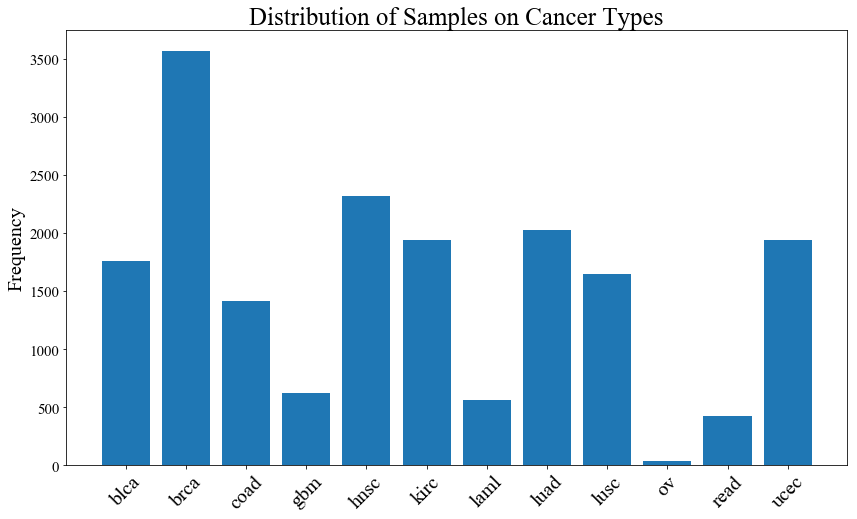

In [3]:
c_types = [n.split('|')[1] for n in meth_all_samples.columns[2:]]
unique, counts = np.unique(c_types, return_counts=True)
fig = plt.figure(figsize=(14, 8))
ax = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Samples on Cancer Types', fontsize=25)
fig.savefig('../../data/pancancer/TCGA/methylation/samples_per_cancertype.svg')

## 2. Mean Samples Across Cancer Types

In [4]:
# first, transpose and add column with cancer type
meth_t = meth_all_samples.T
meth_t['cancer_type'] = [None] + [i[1] for i in meth_t.index.str.split('|')[1:]]

# remove everything that is not a promoter beta value (remove support and gene body methylation)
meth_prom_only = meth_t[meth_t.index.str.contains('beta_value_promoter')]
meth_gene_only = meth_t[meth_t.index.str.contains('beta_value_gene')]

# compute mean across all cancer types
meth_prom_only_mean = meth_prom_only.fillna(0).groupby('cancer_type').mean().T
meth_prom_only_mean['Symbol'] = meth_all_samples.Symbol # reintroduce gene names
meth_prom_only_mean.set_index('Symbol', inplace=True) # set them as index

meth_gene_only_mean = meth_gene_only.fillna(0).groupby('cancer_type').mean().T
meth_gene_only_mean['Symbol'] = meth_all_samples.Symbol # reintroduce gene names
meth_gene_only_mean.set_index('Symbol', inplace=True) # set them as index

In [5]:
# construct dataframe with both, methylation for the promoters and gene bodies
ctypes = meth_prom_only_mean.columns
meth_prom_only_mean['kind'] = 'Promoter'
meth_gene_only_mean['kind'] = 'Gene Body'
both = pd.concat((meth_prom_only_mean, meth_gene_only_mean))

# convert to long format
long_format = pd.melt(both, id_vars=['Symbol', 'kind'], value_vars=list(unique))

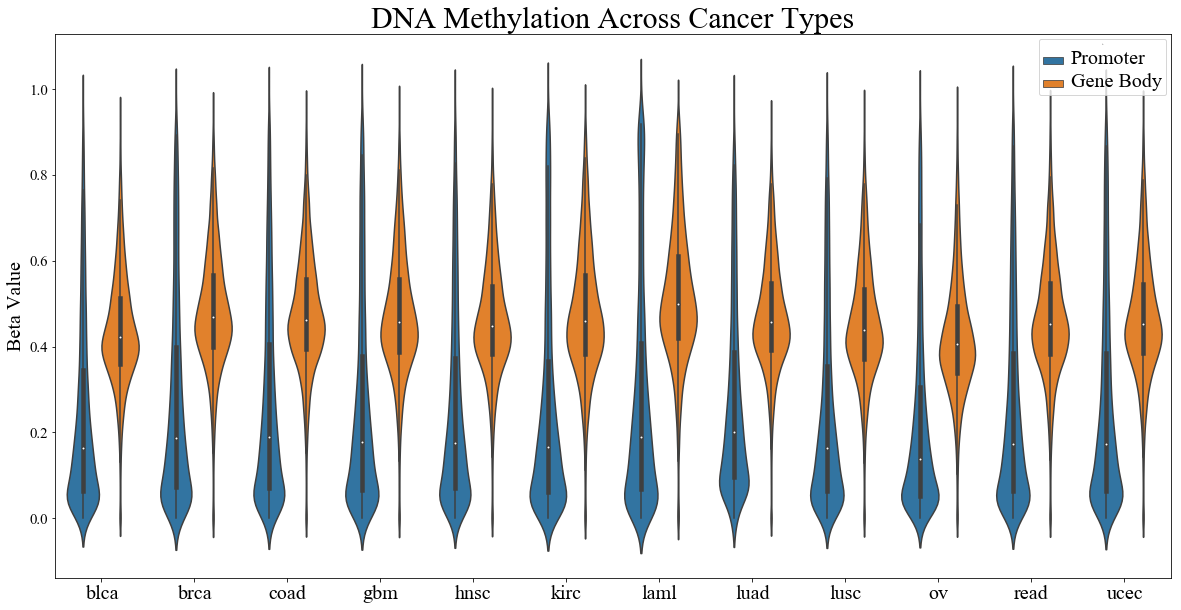

In [6]:
# plot violinplot
fig = plt.figure(figsize=(20, 10))
ax = seaborn.violinplot(x='cancer_type', y='value', hue='kind', data=long_format, dodge=True)
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('DNA Methylation Across Cancer Types', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
_ = plt.setp(ax.get_legend().get_title(), fontsize='0') # make title of legend disappear
fig.savefig('../../data/pancancer/TCGA/methylation/beta_values_cancertype.png')

In [7]:
# now, get the same means for the support
sup_prom_only = meth_t[meth_t.index.str.contains('support_promoter')]
sup_gene_only = meth_t[meth_t.index.str.contains('support_gene')]

# compute mean across all cancer types
sup_prom_only_mean = sup_prom_only.fillna(0).groupby('cancer_type').mean().T
sup_prom_only_mean['Symbol'] = meth_all_samples.Symbol # reintroduce gene names
sup_prom_only_mean.set_index('Symbol', inplace=True) # set them as index

sup_gene_only_mean = sup_gene_only.fillna(0).groupby('cancer_type').mean().T
sup_gene_only_mean['Symbol'] = meth_all_samples.Symbol # reintroduce gene names
sup_gene_only_mean.set_index('Symbol', inplace=True) # set them as index

In [8]:
# construct dataframe with both, methylation for the promoters and gene bodies
ctypes = sup_prom_only_mean.columns
sup_prom_only_mean['kind'] = 'Promoter'
sup_gene_only_mean['kind'] = 'Gene Body'
both = pd.concat((sup_prom_only_mean, sup_gene_only_mean))

# convert to long format
long_format_sup = pd.melt(both, id_vars=['Symbol', 'kind'], value_vars=list(unique))

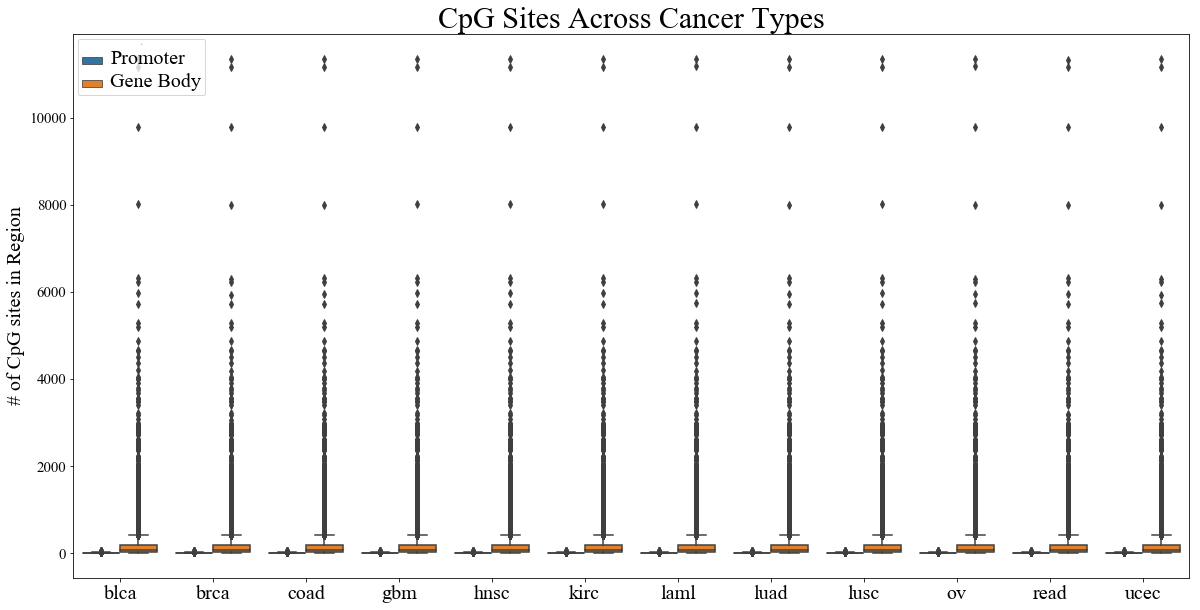

In [9]:
# plot violinplot
fig = plt.figure(figsize=(20, 10))
ax = seaborn.boxplot(x='cancer_type', y='value', hue='kind', data=long_format_sup, dodge=True)
plt.xlabel('')
plt.ylabel('# of CpG sites in Region', fontsize=20)
plt.title('CpG Sites Across Cancer Types', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
_ = plt.setp(ax.get_legend().get_title(), fontsize='0') # make title of legend disappear
fig.savefig('support_means.png')

In [10]:
meth_prom_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_promoters_cancers.tsv', sep='\t')
meth_gene_only_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_matrix_genes_cancers.tsv', sep='\t')

## 3. Integrate Methylation into HDF5 container

array(['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad',
       'lusc', 'ov', 'read', 'ucec'], dtype=object)

In [13]:
# load Container
data_file = '../../data/pancancer/hotnet_iref_vec_input_unbalanced.h5'

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [14]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('ensembl_id', inplace=True)

# add gene body and promoter information
meth_mean_all = pd.concat((meth_prom_only_mean, meth_gene_only_mean), axis=1)
features_all = nodes_df.join(meth_mean_all, on='name')

num_of_zero_nodes = features_all.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any features assigned".format(num_of_zero_nodes, network.shape[0]))
print ("--> left with valid scores for {} genes".format(network.shape[0]-num_of_zero_nodes))

# put 0 for missing data and remove name columns
features_all.fillna(0, inplace=True)
features_all.drop(['name', 'kind'], axis=1, inplace=True)

519 out of 12129 nodes don't have any features assigned
--> left with valid scores for 11610 genes


In [27]:
# get also feature dfs for promoters and genes separately
features_prom = nodes_df.join(meth_prom_only_mean, on='name')
features_gene = nodes_df.join(meth_gene_only_mean, on='name')

# put 0 for missing data and remove name columns
features_prom.fillna(0, inplace=True)
features_prom.drop(['name', 'kind'], axis=1, inplace=True)
features_gene.fillna(0, inplace=True)
features_gene.drop(['name', 'kind'], axis=1, inplace=True)

In [23]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_test, train_mask, test_mask, feature_names):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.close()

    print ("Container written to {}".format(fname))

In [25]:
features = features_all.as_matrix()
write_hdf5_container('../../data/pancancer/iref_methylation_450k1000bpprom_all.h5',
                     network, features, node_names, y_train, y_test, train_mask, test_mask, list(c_types)*2)

Container written to ../../data/pancancer/iref_methylation_450k1000bpprom_all.h5


In [28]:
features = features_prom.as_matrix()
write_hdf5_container('../../data/pancancer/iref_methylation_450k_1000bpprom.h5',
                     network, features, node_names, y_train, y_test, train_mask, test_mask, list(c_types))

Container written to ../../data/pancancer/iref_methylation_450k_1000bpprom.h5


In [29]:
features = features_gene.as_matrix()
write_hdf5_container('../../data/pancancer/iref_methylation_450k_genebody.h5',
                     network, features, node_names, y_train, y_test, train_mask, test_mask, list(c_types))

Container written to ../../data/pancancer/iref_methylation_450k_genebody.h5
